# Dimensionality Reduction

In [36]:
import polars as pl
import polars.selectors as ps
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

Here we analyse the data from a prtuguese wholesale distributor. We'll be preprocessing the data for clustering.

It contains the following features:

* Fresh: annual spending (m.u.) on fresh products
* Milk: annual spending (m.u.) on milk products
* Grocery: annual spending (m.u.) on grocery products
* Frozen: annual spending (m.u.) on frozen products
* Detergents_Paper: annual spending (m.u.) on detergents and paper products
* Delicatessen: annual spending (m.u.) on delicatessen products
* Channel: customer channel (1: hotel/restaurant/cafe or 2: retail)
* Region: customer region (1: Lisbon, 2: Porto, 3: Other)

In this data, the values for all spending are given in an arbitrary unit (m.u. = monetary unit).

In [37]:
df = pl.read_csv("./data/Wholesale_Customers_Data.csv")
df.head()

Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
i64,i64,i64,i64,i64,i64,i64,i64
2,3,12669,9656,7561,214,2674,1338
2,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
1,3,13265,1196,4221,6404,507,1788
2,3,22615,5410,7198,3915,1777,5185


In [38]:
pl.DataFrame(zip(df.columns, df.dtypes), schema=["Column", "Datatype"])

Column,Datatype
str,object
"""Channel""",Int64
"""Region""",Int64
"""Fresh""",Int64
"""Milk""",Int64
"""Grocery""",Int64
"""Frozen""",Int64
"""Detergents_Paper""",Int64
"""Delicassen""",Int64


We'll drop the Channel and Region column since they are categorical

In [39]:
df = df.drop(['Channel', 'Region'])

In [40]:
df = df.with_columns(pl.all().cast(pl.Float64))

In [41]:
df_orig = df.clone()

## Preprocessing

We need to scale the data before we can use dimensionality reduction effectively. We also want to remove skew. Finally we'll show the correlations within the data.

In [42]:
corr = (
    df
    # Select only numeric values
    .select(ps.numeric())
    # Calculate correlation matrix
    .corr()
    # Pipe correlation matrix for further processing
    .pipe(
        lambda c: 
            # Replace the diagonal values with 0.0
            c.with_columns([
                pl.when(pl.arange(0, c.height) == i)
                .then(0.0)
                .otherwise(pl.col(col))
                .alias(col)
            for i, col in enumerate(c.columns)
            ])
    )
)

max_corr_idx = (
    corr
    # Find the index of the maximum value for each column
    .with_columns(pl.all().abs().arg_max())
    # Only keep one copy (resulting df still has dimension (n_cols x n_cols))
    .row(0)
)

res = {"feat_1": [], "feat_2":[], "correlation": []}
for feat, idx in zip(corr.columns, max_corr_idx):
#    for col in df.columns:
    res["feat_1"].append(feat)
    res["feat_2"].append(corr.columns[idx])
    res["correlation"].append(corr[feat][idx])

largest_correlations = pl.DataFrame(res)

largest_correlations.sort(by="correlation").show(None)

feat_1,feat_2,correlation
str,str,f64
"""Fresh""","""Frozen""",0.345881
"""Frozen""","""Delicassen""",0.390947
"""Delicassen""","""Milk""",0.406368
"""Milk""","""Grocery""",0.728335
"""Grocery""","""Detergents_Paper""",0.924641
"""Detergents_Paper""","""Grocery""",0.924641


In [43]:
skew_values = (
    df
    .select(ps.numeric())
    .select(pl.all().skew())
    .transpose(include_header=True)
    .rename({'column': 'feature', 'column_0': 'skew_value'})
    .filter(pl.col('skew_value') > 0.75)
    .sort('skew_value', descending=True)
)

skew_values

feature,skew_value
str,f64
"""Delicassen""",11.113534
"""Frozen""",5.887826
"""Milk""",4.039922
"""Detergents_Paper""",3.619458
"""Grocery""",3.575187
"""Fresh""",2.552583


Looks like all the columns are significantly skewed. Let's fix that.

In [44]:
df_unskewed = (
    df
    .with_columns([
        pl.col(col).log1p()
        for col in skew_values['feature']
    ])
)

Finally, let's scale the data with the MinMaxScaler

In [45]:
mms = MinMaxScaler()

scaled = mms.fit_transform(df_unskewed)

df_scaled = df_unskewed.with_columns([
    pl.Series(col, scaled[:, i])
    for i, col in enumerate(df_unskewed.columns)
])

To make use of the seaborn plot functionality, we need to transform the polars frame to a pandas frame.

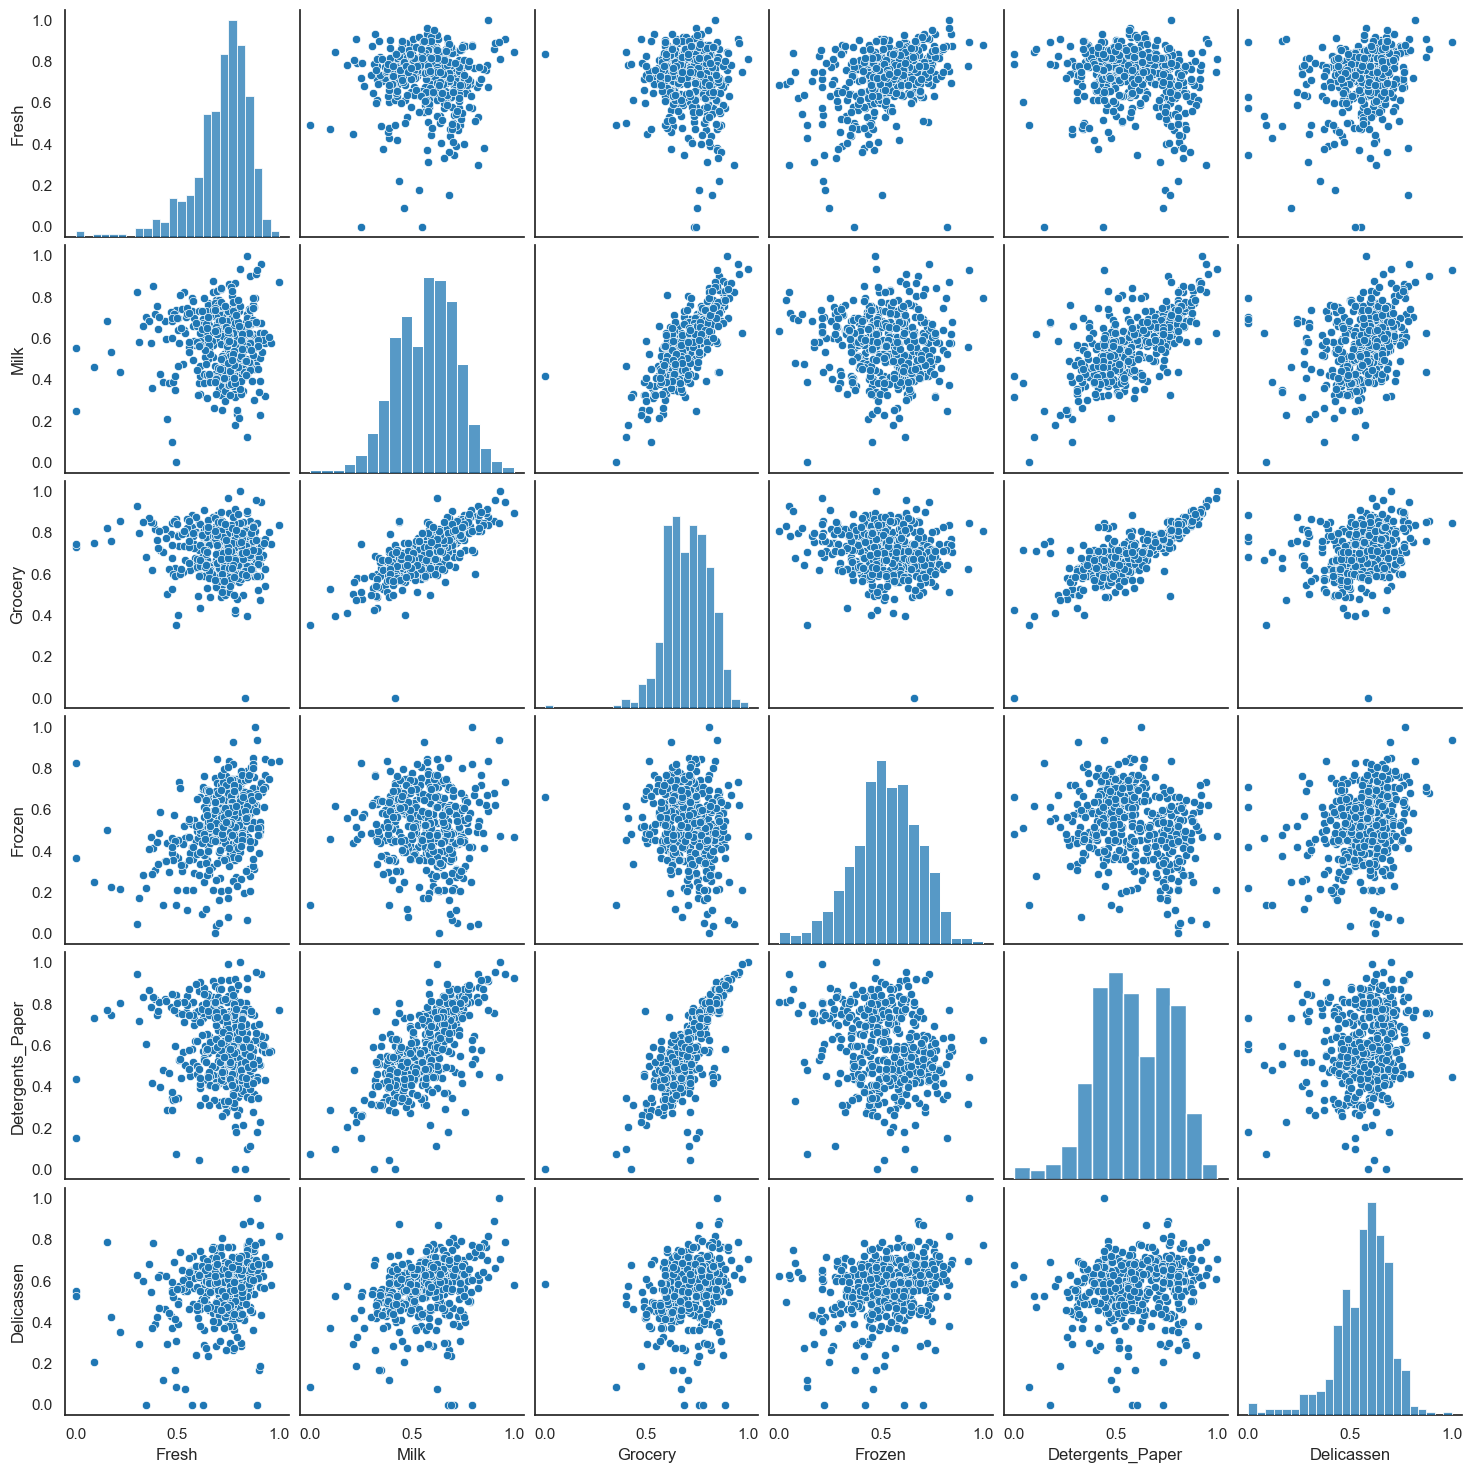

In [46]:
sns.set_context('notebook')
sns.set_style('white')
sns.pairplot(df_scaled.to_pandas());

## Pipeline setup

We can build a processing pipeline of our preprocessing steps. We'll pass the original data to show that this is equivalent to the previous steps

In [50]:
# Create a custom log1p function that can be used in the pipeline
log_transformer = FunctionTransformer(np.log1p)

estimators = [('log1p', log_transformer), ('scaler', MinMaxScaler())]
pipeline = Pipeline(estimators)

data_piped = pipeline.fit_transform(df_orig)

In [53]:
np.allclose(data_piped, df_scaled)

True

There is one disadvantage here, however. Running the pipeline automatically converts to a numpy array, which makes us lose the power of polars dataframes. We could write custom functions that handle this by using FunctionTransformer, but that is not worth it in this case.

In [54]:
type(data_piped), type(df_scaled)

(numpy.ndarray, polars.dataframe.frame.DataFrame)

## PCA

We'll perform PCA with varying numbers of components, then check the amount of explained variance. We can also check the feature importance this way by calculating the amount each component attributes to a specific feature.

In [ ]:
pca_list = list()
feature_weight_list = list()

for n in range(1, 6):
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(df_scaled)
    
    # Store the model and variance
    pca_list.append(pl.DataFrame({'n':n, 'model': PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pl.DataFrame({'n':n, 
                                             'features': df_scaled.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pl.concat(pca_list)
pca_df

n,model,var
i64,object,f64
1,PCA(n_components=1),0.448011
2,PCA(n_components=2),0.72099
3,PCA(n_components=3),0.827534
4,PCA(n_components=4),0.923045
5,PCA(n_components=5),0.979574


So with 5 components we are able to explain 98% of the variance in the data.

In [68]:
features_df = pl.concat(feature_weight_list).pivot(on="features", values="values", index="n")

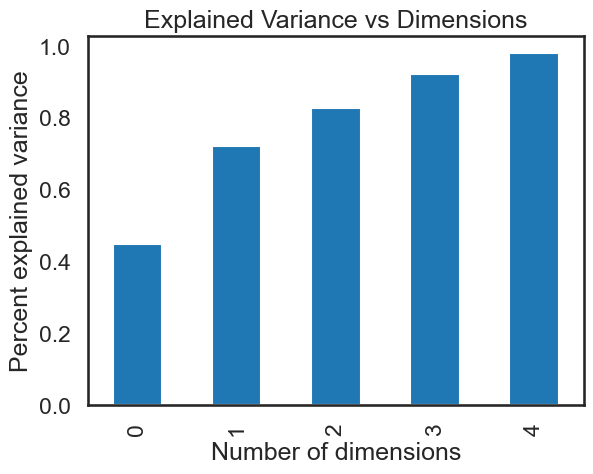

In [69]:
sns.set_context('talk')
ax = pca_df.to_pandas()['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

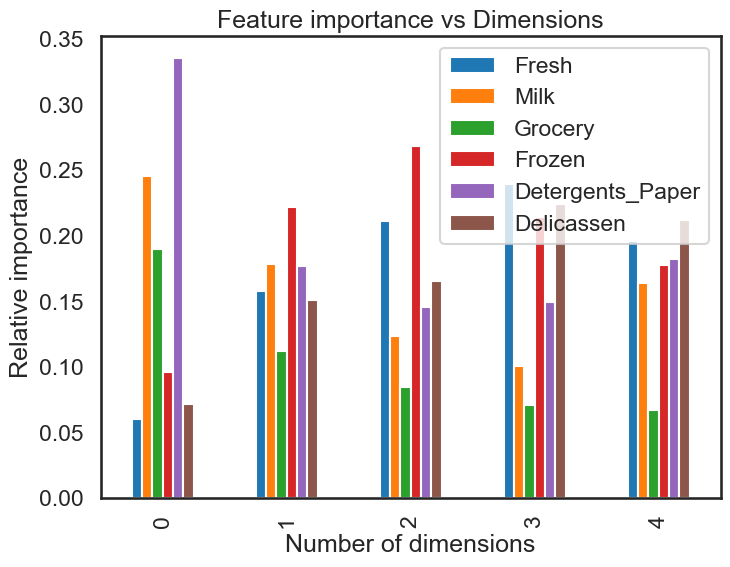

In [73]:
ax = features_df.to_pandas().drop(columns=['n']).plot(kind='bar', figsize=(8,6))
ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');